In [1]:
import re
import json
import os

def preprocess(text):
    punctuations = "，。！？；：“”（）"
    input_text = ""
    punctuation_indices = []
    punctuation_types = []

    for idx, char in enumerate(text):
        if char in punctuations:
            punctuation_indices.append(len(input_text))
            punctuation_types.append(char)
        else:
            input_text += char

    return input_text, punctuation_indices, punctuation_types


In [2]:
def process_folder(folder_path, output_file):
    data_points = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                for i, line in enumerate(lines):
                    line = line.strip()
                    if not line:
                        continue  # 跳过空行
                    input_text, indices, types = preprocess(line)
                    data_point = {
                        "filename": filename,
                        "line_number": i + 1,
                        "input_text": input_text,
                        "punctuation_indices": indices,
                        "punctuation_types": types
                    }
                    data_points.append(data_point)

    # 写入 JSONL 文件
    with open(output_file, 'w', encoding='utf-8') as out_f:
        for dp in data_points:
            out_f.write(json.dumps(dp, ensure_ascii=False) + "\n")

    print(f"✅ 共处理了 {len(data_points)} 条 data points，输出文件：{output_file}")

In [3]:
if __name__ == "__main__":
    folder_path = "Corpus/十國春秋_cleaned"  # 这里填你的 txt 文件夹路径
    output_file = "processed_data_sgcq.jsonl"  # 输出文件名
    process_folder(folder_path, output_file)

✅ 共处理了 6774 条 data points，输出文件：processed_data_sgcq.jsonl


In [4]:
import json
from tqdm import tqdm

# 标点映射为数字标签
punctuation_map = {
    "，": 1,
    "。": 2,
    "？": 3,
    "！": 4,
    "；": 5,
    "：": 6,
    "“": 7,
    "”": 7,
    "‘": 8,
    "’": 8,
    "（": 9,
    "）": 9
}

# 字符级输入和标签构造
def build_dataset(jsonl_path, vocab=None):
    all_X = []
    all_y = []
    char2idx = {} if vocab is None else vocab
    idx = 1  # 0留给padding

    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Processing"):
            data = json.loads(line)
            input_text = data["input_text"]
            punct_indices = data["punctuation_indices"]
            punct_types = data["punctuation_types"]

            # 编码 input_text 为字符ID序列
            X = []
            for ch in input_text:
                if vocab is None:
                    if ch not in char2idx:
                        char2idx[ch] = idx
                        idx += 1
                X.append(char2idx.get(ch, 0))  # 0 表示未登录词

            # 构造标签序列：与字符对齐（每个字后一个标记）
            y = [0] * len(input_text)
            for i, punct in zip(punct_indices, punct_types):
                if i < len(y):  # 安全检查
                    y[i] = punctuation_map.get(punct, 0)  # 未知标点归为0（不加）

            all_X.append(X)
            all_y.append(y)

    return all_X, all_y, char2idx

X, y, char2idx = build_dataset("processed_data_sgcq.jsonl")

with open("char2idx.json", "w", encoding="utf-8") as f:
    json.dump(char2idx, f, ensure_ascii=False)



Processing: 6774it [00:00, 127553.75it/s]


In [5]:
jsonl_file = "processed_data_sgcq.jsonl"
X, y, vocab = build_dataset(jsonl_file)

print("样本数量：", len(X))
print("第一个输入序列（字符ID）:", X[0])
print("第一个标签序列：", y[0])
print("字符表大小：", len(vocab))


Processing: 6774it [00:00, 69818.49it/s]

样本数量： 6774
第一个输入序列（字符ID）: [1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 5, 10, 11, 12, 2, 3, 4, 5, 13, 6, 7, 8, 14, 2, 15, 16]
第一个标签序列： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
字符表大小： 5166


In [6]:
# !pip install tensorflow

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def build_punctuation_model(vocab_size, num_classes, embedding_dim=128, lstm_units=128):
    input_seq = Input(shape=(None,), dtype='int32')  # [batch_size, seq_len]

    x = Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, mask_zero=True)(input_seq)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

    model = Model(inputs=input_seq, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

X, y, char2idx = build_dataset("processed_data_sgcq.jsonl")
max_len = max(len(seq) for seq in X)
X_pad = pad_sequences(X, maxlen=max_len, padding='post')
y_pad = pad_sequences(y, maxlen=max_len, padding='post')
y_pad = np.expand_dims(y_pad, -1)


Processing: 6774it [00:00, 101110.37it/s]


In [9]:
NUM_CLASSES = 10

model = build_punctuation_model(vocab_size=len(vocab), num_classes=NUM_CLASSES)

model.fit(X_pad, y_pad, batch_size=32, epochs=10, validation_split=0.1)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9076 - loss: 0.8607 - val_accuracy: 0.9286 - val_loss: 0.4120
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9276 - loss: 0.3921 - val_accuracy: 0.9367 - val_loss: 0.3311
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9345 - loss: 0.3268 - val_accuracy: 0.9418 - val_loss: 0.2964
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.9397 - loss: 0.2917 - val_accuracy: 0.9440 - val_loss: 0.2809
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9438 - loss: 0.2713 - val_accuracy: 0.9441 - val_loss: 0.2790
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9471 - loss: 0.2524 - val_accuracy: 0.9457 - val_loss: 0.2731
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9506 - loss: 0.2357 - val_accuracy: 0.9452 - val_loss: 0.2819
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9533 - loss: 0.

212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


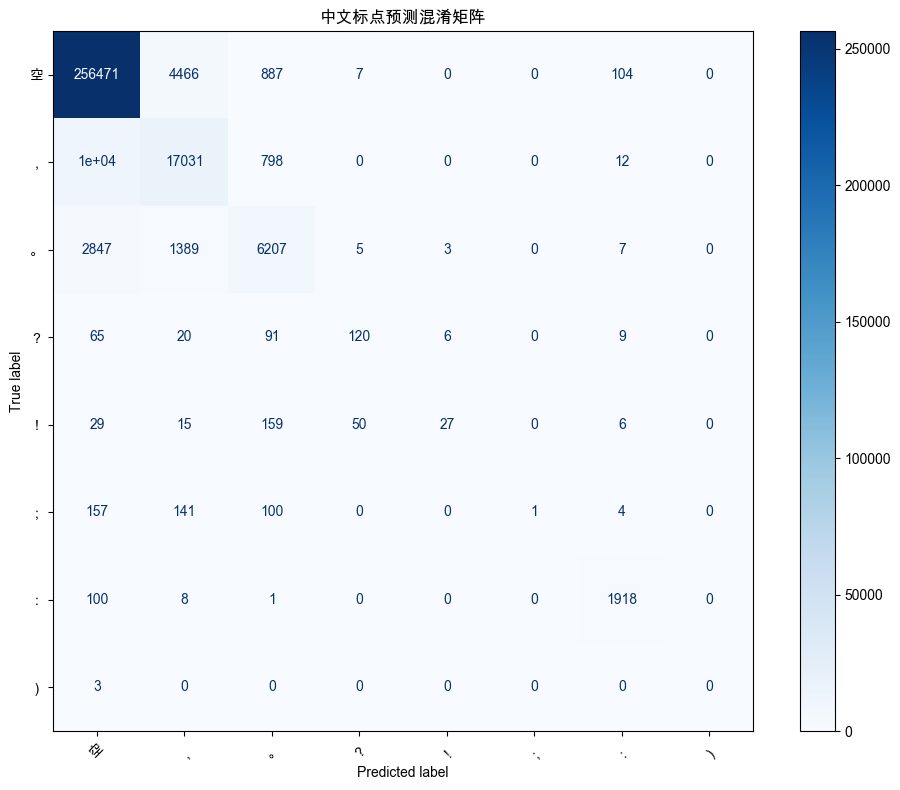


分类报告（Precision / Recall / F1-Score）：

              precision    recall  f1-score   support

           空     0.9505    0.9791    0.9646    261935
           ，     0.7382    0.6084    0.6670     27995
           。     0.7530    0.5935    0.6638     10458
           ？     0.6593    0.3859    0.4868       311
           ！     0.7500    0.0944    0.1677       286
           ；     1.0000    0.0025    0.0050       403
           ：     0.9311    0.9462    0.9386      2027
           ）     0.0000    0.0000    0.0000         3

    accuracy                         0.9287    303418
   macro avg     0.7228    0.4512    0.4867    303418
weighted avg     0.9236    0.9287    0.9241    303418


总体 Accuracy: 0.9287


/Users/xinleichen/miniconda3/envs/ancient-punc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xinleichen/miniconda3/envs/ancient-punc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xinleichen/miniconda3/envs/ancient-punc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# 设置中文字体（根据系统情况调整）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 也可换成 SimHei、Noto Sans CJK SC
plt.rcParams['axes.unicode_minus'] = False

# ===== 1. 标点映射表 =====
punctuation_map = {
    "，": 1, "。": 2, "？": 3, "！": 4,
    "；": 5, "：": 6, "“": 7, "”": 7,
    "‘": 8, "’": 8, "（": 9, "）": 9
}
idx2punct = {v: k for k, v in punctuation_map.items()}
idx2punct[0] = "空"

# ===== 2. 模型预测 =====
y_pred_prob = model.predict(X_pad)
y_pred = np.argmax(y_pred_prob, axis=-1)

# ===== 3. 扁平化并忽略 padding =====
y_true_flat = []
y_pred_flat = []

for i in range(len(y_pad)):
    for j in range(len(y_pad[i])):
        if X_pad[i][j] != 0:
            y_true_flat.append(y_pad[i][j][0])
            y_pred_flat.append(y_pred[i][j])

# ===== 4. 标签种类和名称 =====
labels = sorted(set(y_true_flat + y_pred_flat))
display_labels = [idx2punct.get(i, str(i)) for i in labels]

# ===== 5. 混淆矩阵 =====
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)

# 设置字体
for label in ax.get_xticklabels():
    label.set_fontname("Arial Unicode MS")
for label in ax.get_yticklabels():
    label.set_fontname("Arial Unicode MS")

plt.title("中文标点预测混淆矩阵", fontname="Arial Unicode MS")
plt.tight_layout()
plt.show()

# ===== 6. 打印 F1-score 等指标 =====
target_names = display_labels
print("\n分类报告（Precision / Recall / F1-Score）：\n")
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=target_names, digits=4))

# ===== 7. 准确率 =====
acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"\n总体 Accuracy: {acc:.4f}")


In [12]:
model.save("model_10.h5")

with open("char2idx.json", "r", encoding="utf-8") as f:
    char2idx = json.load(f)


In [13]:
# 如果你已经有 punctuation_map，就可以自动构造反向映射：
punctuation_id2char = {0: "", 1: "，", 2: "。", 3: "？", 4: "！", 5: "；", 6: "：", 7: "”", 8: "’", 9: "）"}

# 记录左右标点状态（用于自动匹配开/闭）
quote_states = {
    7: True,  # True 表示下一次是左引号 “
    8: True,  # ‘
    9: True   # （
}

# 推理时使用这个函数
def resolve_punctuation(label_id):
    if label_id not in [7, 8, 9]:
        # 非对称标点直接映射
        return {
            1: "，", 2: "。", 3: "？", 4: "！", 5: "；", 6: "："
        }.get(label_id, "")
    
    # 对称标点，根据状态返回左或右
    if label_id == 7:
        result = "“" if quote_states[7] else "”"
        quote_states[7] = not quote_states[7]
        return result
    elif label_id == 8:
        result = "‘" if quote_states[8] else "’"
        quote_states[8] = not quote_states[8]
        return result
    elif label_id == 9:
        result = "（" if quote_states[9] else "）"
        quote_states[9] = not quote_states[9]
        return result


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_punctuation(text, model, char2idx, punctuation_id2char, max_len=200):
    chars = list(text)
    input_ids = [char2idx.get(ch, 0) for ch in chars]
    input_ids = pad_sequences([input_ids], maxlen=max_len, padding='post')

    preds = model.predict(input_ids)[0]  # shape: (seq_len, num_classes)
    pred_classes = np.argmax(preds, axis=-1)

    # 还原带标点的文本
    result = ""
    for i, ch in enumerate(chars):
        result += ch
        label = pred_classes[i]
        if label != 0:  # 需要加标点
            result += resolve_punctuation(label)

    return result


In [19]:
test_text = "臣亮言先帝创业未半而中道崩殂今天下三分益州疲弊"
output_text = predict_punctuation(test_text, model, char2idx, punctuation_id2char)
print("原文（无标点）:", test_text)
print("预测（加标点）:", output_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
原文（无标点）: 臣亮言先帝创业未半而中道崩殂今天下三分益州疲弊
预测（加标点）: 臣亮言先帝创业未半而，中道崩殂今，天下三分益，州疲弊


In [20]:
test_text = "亲贤臣远小人此先汉所以兴隆也亲小人远贤臣此后汉所以倾颓也"
output_text = predict_punctuation(test_text, model, char2idx, punctuation_id2char)
print("原文（无标点）:", test_text)
print("预测（加标点）:", output_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
原文（无标点）: 亲贤臣远小人此先汉所以兴隆也亲小人远贤臣此后汉所以倾颓也
预测（加标点）: 亲贤臣远小人此，先汉所以兴隆也亲小。人远贤臣此后汉所以倾颓也
